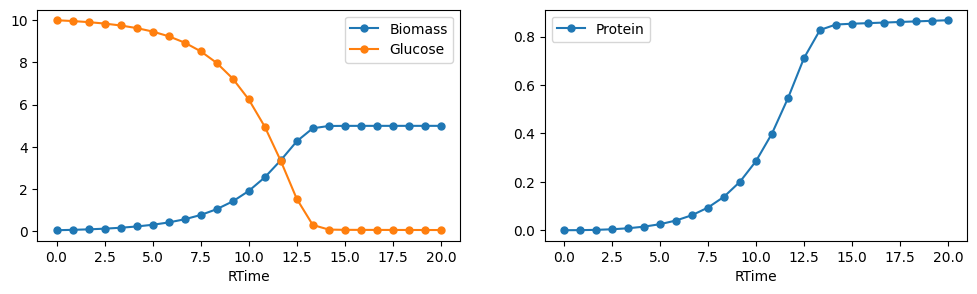

In [59]:
from typing import Union

from matplotlib import markers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from tqdm import tqdm

pd.options.mode.chained_assignment = None
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

T_START = 0
T_END = 20
NUM_SAMPLES = 25

# parameter values
mumax = 0.45      # 1/hour
Ks = 1.00         # g/liter
Yxs = 0.5         # g/g
Ypx = 0.2         # g/g
Sin = 10.0         # g/liter

# inlet flowrate
def Fs(t):
    return 0.05

# reaction rates
def mu(S):
    return mumax*S/(Ks + S)

def Rg(X,S):
    return mu(S)*X
    
def Rp(X,S):
    return Ypx*Rg(X,S)

def a(t):
    return Ypx * (1 - np.exp(-Ypx*t))

# differential equations
def xdot(x,t):
    X,P,S,V = x
    dX = -Fs(t)*X/V + Rg(X,S)
    dP = -Fs(t)*P/V + a(t) * Rg(X, S)
    dS = Fs(t)*(Sin-S)/V - Rg(X,S)/Yxs
    dV = Fs(t)
    return [dX,dP,dS,dV]

IC = [0.05, 0.0, 10.0, 1.0]

t = np.linspace(T_START,T_END,NUM_SAMPLES)
sol = odeint(xdot,IC,t)
X,P,S,V = sol.transpose()

# Generate dataset 
df = pd.DataFrame({'RTime': t, 'Biomass': X, 'Glucose': S, 'V': V, 'Protein': P})

# Plot 
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
df.plot(x='RTime', y=['Biomass', 'Glucose'], ax=ax[0], marker='o', markersize=5)
df.plot(x='RTime', y='Protein', ax=ax[1], marker='o', markersize=5)
plt.show()

In [60]:
def numpy_to_tensor(array):
    return (
        torch.tensor(array, requires_grad=True, dtype=torch.float32)
        .to(DEVICE)
        .reshape(-1, 1)
    )

class PINN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        t_start: Union[np.float32, torch.Tensor],
        t_end: Union[np.float32, torch.Tensor],
    ):
        super(PINN, self).__init__()
        self.input = nn.Linear(input_dim, 64)
        self.fc1 = nn.Linear(64, 1024)
        self.hidden = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 64)
        self.output = nn.Linear(64, output_dim)

        # Kinetic parameters
        self.mu_max = nn.Parameter(torch.tensor([0.35]))

        # Modeling protein production
        self.c1 = nn.Parameter(torch.tensor([0.3]))
        self.c2 = nn.Parameter(torch.tensor([0.3]))
        self.c3 = nn.Parameter(torch.tensor([0.2]))
        self.c4 = nn.Parameter(torch.tensor([0.2]))
       
        self.t_start = t_start
        self.t_end = t_end
        if isinstance(self.t_start, torch.Tensor):
            self.t_start = self.t_start.item()
        if isinstance(self.t_end, torch.Tensor):
            self.t_end = self.t_end.item()

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self.fc1(x))
        x = torch.tanh(self.hidden(x))
        x = torch.relu(self.fc2(x))
        x = self.output(x)
        return x
    
def loss_fn(
    net: torch.nn.Module,
    scaffold: int, 
    t_start: Union[np.float32, torch.Tensor] = T_START,
    t_end: Union[np.float32, torch.Tensor] = T_END,
) -> torch.Tensor:

    def alpha(scaffold, t):
        if scaffold == 1: 
            return net.c1
        elif scaffold == 2:
            return (net.c1 * t**2 + net.c2 * t + net.c3) / 10
        elif scaffold == 3:
            return net.c1 * torch.log(1 + t) + net.c3 * (1 - torch.exp(-net.c4 * t**2))
    
    if isinstance(t_start, torch.Tensor):
        t_start = t_start.item()
    if isinstance(t_end, torch.Tensor):
        t_end = t_end.item()

    t = torch.linspace(t_start, t_end, steps=80,).view(-1, 1).requires_grad_(True)
    F = torch.tensor([Fs(t) for t in t], dtype=torch.float32).view(-1, 1)

    u_pred = net.forward(t)
    X_pred = u_pred[:, 0].view(-1, 1)
    S_pred = u_pred[:, 1].view(-1, 1)
    V_pred = u_pred[:, 2].view(-1, 1)
    P_pred = u_pred[:, 3].view(-1, 1) 

    dXdt_pred = torch.autograd.grad(X_pred, t, grad_outputs=torch.ones_like(X_pred), create_graph=True)[0]
    dSdt_pred = torch.autograd.grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    dVdt_pred = torch.autograd.grad(V_pred, t, grad_outputs=torch.ones_like(V_pred), create_graph=True)[0]
    dPdt_pred = torch.autograd.grad(P_pred, t, grad_outputs=torch.ones_like(P_pred), create_graph=True)[0]

    mu = net.mu_max * S_pred / (Ks + S_pred)
    
    error_dXdt = nn.MSELoss()(
        dXdt_pred, mu * X_pred - X_pred * F / V_pred
    ) * 0.8
    error_dSdt = nn.MSELoss()(
        dSdt_pred, - mu * X_pred / Yxs + F / V_pred * (Sin - S_pred)
    ) * 0.8
    error_dVdt = nn.MSELoss()(
        dVdt_pred, F
    ) * 0.2
    error_dPdt = nn.MSELoss()(
        dPdt_pred, alpha(scaffold, t) * mu * X_pred - P_pred * F / V_pred
    ) * 1

    error_ode = error_dXdt + error_dSdt + error_dVdt + error_dPdt 

    return error_ode


In [61]:
def main(train_df: pd.DataFrame, full_df: pd.DataFrame, scaffold: int, num_epochs: int = 10000):
    
    t_start, t_end = train_df['RTime'].min(), train_df['RTime'].max()
    t_train = numpy_to_tensor(train_df['RTime'].values)
    X_train = numpy_to_tensor(train_df['Biomass'].values)
    S_train = numpy_to_tensor(train_df["Glucose"].values)
    P_train = numpy_to_tensor(train_df["Protein"].values)
    V_train = numpy_to_tensor(train_df["V"].values)

    u_train = torch.cat((X_train, S_train, V_train, P_train), dim=1).to(DEVICE)
    net = PINN(1, 4, t_start, t_end).to(DEVICE)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    w_data, w_ode, w_ic = 1, 1, 0.2

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        u_pred = net.forward(t_train)

        loss_data = nn.MSELoss()(u_pred, u_train) * w_data
        loss_ode = loss_fn(net, scaffold, T_START, T_END) * w_ode
        loss_ic = nn.MSELoss()(u_pred[0, :], u_train[0, :]) * w_ic

        loss = loss_data + loss_ode + loss_ic
        loss.backward()
        optimizer.step()

        if epoch == 0:
            if torch.any(u_pred < 0):
                raise ValueError("u_pred has negative values")
            
        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Loss Data: {loss_data.item():.4f}, Loss ODE: {loss_ode.item():.4f}, Loss IC: {loss_ic.item():.4f}")
            print(f"mu_max: {net.mu_max.item():.2f}, c1: {net.c1.item():.2f}, c2: {net.c2.item():.2f}, c3: {net.c3.item():.2f}, c4: {net.c4.item():.2f}")

        # Early stopping
        if loss.item() < 0.0005:
            break

    t_test = numpy_to_tensor(full_df['RTime'].values)
    u_pred = pd.DataFrame(net.forward(t_test).detach().cpu().numpy())
    u_pred.columns = ["Biomass", "Glucose", "V", "Protein"]
    u_pred['RTime'] = t_test.detach().cpu().numpy()

    return net, u_pred

In [62]:
df.shape

(25, 5)

In [63]:
# Select training data
train_df = df.iloc[:5].copy()

In [64]:
# Train the model and get results
repeat = True
while repeat:
    try:
        net_A, u_pred_A = main(train_df, df, scaffold=1, num_epochs=5000)
        repeat = False
    except ValueError:
        pass

repeat = True
while repeat:
    try:
        net_B, u_pred_B = main(train_df, df, scaffold=2, num_epochs=5000)        
        repeat = False
    except ValueError:
        pass

repeat = True
while repeat:
    try:
        net_C, u_pred_C = main(train_df, df, scaffold=3, num_epochs=5000)        
        repeat = False
    except ValueError:
        pass

Epoch 1/5000, Loss: 10209.6377, Loss Data: 24.0546, Loss ODE: 10180.6641, Loss IC: 4.9189
mu_max: 0.35, c1: 0.30, c2: 0.30, c3: 0.20, c4: 0.20
Epoch 101/5000, Loss: 0.4926, Loss Data: 0.3894, Loss ODE: 0.0469, Loss IC: 0.0563
mu_max: 0.31, c1: 0.26, c2: 0.30, c3: 0.20, c4: 0.20
Epoch 201/5000, Loss: 0.0996, Loss Data: 0.0621, Loss ODE: 0.0254, Loss IC: 0.0122
mu_max: 0.31, c1: 0.25, c2: 0.30, c3: 0.20, c4: 0.20
Epoch 301/5000, Loss: 0.0048, Loss Data: 0.0012, Loss ODE: 0.0034, Loss IC: 0.0003
mu_max: 0.31, c1: 0.25, c2: 0.30, c3: 0.20, c4: 0.20
Epoch 401/5000, Loss: 0.0027, Loss Data: 0.0003, Loss ODE: 0.0023, Loss IC: 0.0001
mu_max: 0.31, c1: 0.25, c2: 0.30, c3: 0.20, c4: 0.20
Epoch 501/5000, Loss: 0.0020, Loss Data: 0.0002, Loss ODE: 0.0018, Loss IC: 0.0000
mu_max: 0.31, c1: 0.25, c2: 0.30, c3: 0.20, c4: 0.20
Epoch 601/5000, Loss: 0.0016, Loss Data: 0.0002, Loss ODE: 0.0014, Loss IC: 0.0000
mu_max: 0.31, c1: 0.25, c2: 0.30, c3: 0.20, c4: 0.20
Epoch 701/5000, Loss: 0.0014, Loss Data: 

KeyboardInterrupt: 

In [ ]:
# If u_pred have negatives values, make them zero
u_pred_A[u_pred_A < 0] = 0
u_pred_B[u_pred_B < 0] = 0
u_pred_C[u_pred_C < 0] = 0

In [ ]:
print("Model A")
print(f'mu_max: {net_A.mu_max.item():.6f}, c1: {net_A.c1.item():.6f}')
print("Model B")
print(f'mu_max: {net_B.mu_max.item():.6f}, c1: {net_B.c1.item():.6f}, c2: {net_B.c2.item():.6f}, c3: {net_B.c3.item():.6f}, c4: {net_B.c4.item():.6f}')
print("Model C")
print(f'mu_max: {net_C.mu_max.item():.6f}, c1: {net_C.c1.item():.6f}, c2: {net_C.c2.item():.6f}, c3: {net_C.c3.item():.6f}, c4: {net_C.c4.item():.6f}')

Model A
mu_max: 0.248418, c1: 0.182177
Model B
mu_max: 0.254133, c1: 0.188386, c2: 0.102362, c3: -0.280900, c4: 0.200000
Model C
mu_max: 0.173476, c1: 0.144091, c2: 0.300000, c3: 0.067741, c4: -0.001653


__Data points:__ 25

- `Model A` - mu_max: 0.433333, c1: 0.175519
- `Model B` - mu_max: 0.436013, c1: 0.010556, c2: 0.028939, c3: -0.042542, c4: 0.200000
- `Model C` - mu_max: 0.433718, c1: 0.077370, c2: 0.300000, c3: -0.023167, c4: 0.014329

__Data points:__ 22
- `Model A` - mu_max: 0.434461, c1: 0.174613
- `Model B` - mu_max: 0.442722, c1: 0.010278, c2: 0.033651, c3: -0.041408, c4: 0.200000
- `Model C` - mu_max: 0.435757, c1: 0.080547, c2: 0.300000, c3: -0.018515, c4: 0.108225


__Data points:__ 20
- `Model A` - mu_max: 0.442785, c1: 0.173571
- `Model B` - mu_max: 0.447869, c1: 0.010045, c2: 0.034257, c3: -0.039834, c4: 0.200000
- `Model C` - mu_max: 0.436368, c1: 0.074049, c2: 0.300000, c3: -0.005362, c4: 0.073340


__Data points:__ 18
- `Model A` - mu_max: 0.435731, c1: 0.177674
- `Model B` - mu_max: 0.443953, c1: -0.007278, c2: 0.204070, c3: 0.346977, c4: 0.200000
- `Model C` - mu_max: 0.442672, c1: 0.078942, c2: 0.300000, c3: -0.019101, c4: 0.135705


__Data points:__ 15
- `Model A` - mu_max: 0.447967, c1: 0.170167
- `Model B` - mu_max: 0.439572, c1: 0.009612, c2: 0.050098, c3: 0.005889, c4: 0.200000
- `Model C` - mu_max: 0.435952, c1: 0.072129, c2: 0.300000, c3: -0.001127, c4: 0.166768


__Data points:__ 12
- `Model A` - mu_max: 0.316875, c1: 0.193961
- `Model B` - mu_max: 0.198914, c1: -0.023150, c2: 0.315713, c3: 0.712616, c4: 0.200000
- `Model C` - mu_max: 0.215972, c1: 0.134722, c2: 0.300000, c3: 0.140874, c4: -0.004320


__Data points:__ 10
- `Model A` - mu_max: 0.215439, c1: 0.210906
- `Model B` - mu_max: 0.185198, c1: -0.004539, c2: 0.281756, c3: 0.755453, c4: 0.200000
- `Model C` - mu_max: 0.233922, c1: 0.131539, c2: 0.300000, c3: 0.118425, c4: -0.003549


__Data points:__ 8
- `Model A` - mu_max: 0.248418, c1: 0.182177
- `Model B` - mu_max: 0.254133, c1: 0.188386, c2: 0.102362, c3: -0.280900, c4: 0.200000
- `Model C` - mu_max: 0.173476, c1: 0.144091, c2: 0.300000, c3: 0.067741, c4: -0.001653

__Data points:__ 5


__Data points:__ 3


__Data points:__ 2


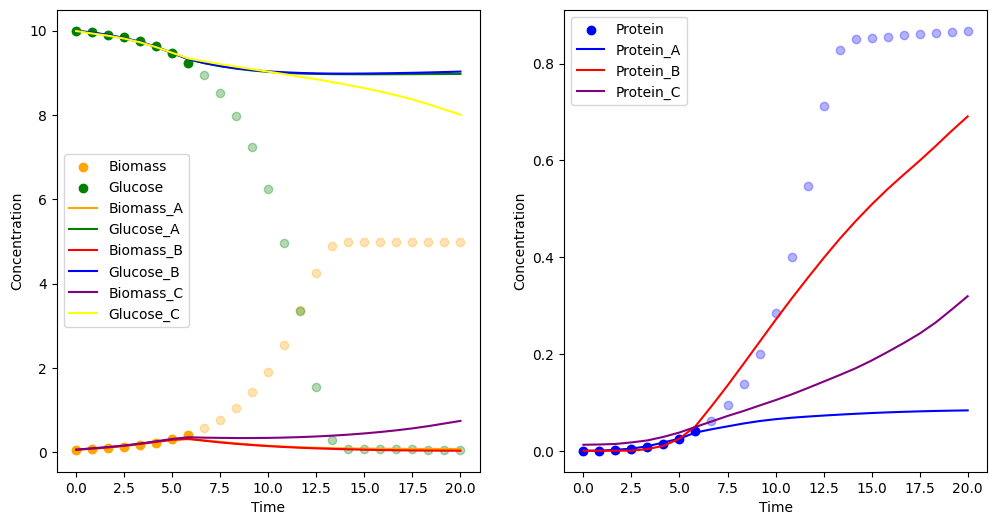

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(df['RTime'], df['Biomass'], color='orange', label="_Biomass", alpha=0.3)
ax[0].scatter(df['RTime'], df['Glucose'], color='green', label="_Glucose", alpha=0.3)
ax[0].scatter(train_df['RTime'], train_df['Biomass'], color='orange', label='Biomass', alpha=1.0)
ax[0].scatter(train_df['RTime'], train_df['Glucose'], color='green', label='Glucose', alpha=1.0)
ax[1].scatter(df['RTime'], df['Protein'], color='blue', label='_Protein', alpha=0.3)   
ax[1].scatter(train_df['RTime'], train_df['Protein'], color='blue', label='Protein', alpha=1.0)

ax[0].plot(u_pred_A['RTime'], u_pred_A['Biomass'], color='orange', label='Biomass_A')
ax[0].plot(u_pred_A['RTime'], u_pred_A['Glucose'], color='green', label='Glucose_A')
ax[0].plot(u_pred_B['RTime'], u_pred_B['Biomass'], color='red', label='Biomass_B')
ax[0].plot(u_pred_B['RTime'], u_pred_B['Glucose'], color='blue', label='Glucose_B')
ax[0].plot(u_pred_C['RTime'], u_pred_C['Biomass'], color='purple', label='Biomass_C')
ax[0].plot(u_pred_C['RTime'], u_pred_C['Glucose'], color='yellow', label='Glucose_C')
ax[1].plot(u_pred_A['RTime'], u_pred_A['Protein'], color='blue', label='Protein_A')
ax[1].plot(u_pred_B['RTime'], u_pred_B['Protein'], color='red', label='Protein_B')
ax[1].plot(u_pred_C['RTime'], u_pred_C['Protein'], color='purple', label='Protein_C')

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Concentration')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Concentration')

plt.savefig(f'../plots/induction_{len(train_df)}.png')
plt.show()

In [ ]:
### MODEL A
mu_max_A = net_A.mu_max.item()

### MODEL B
mu_max_B = net_B.mu_max.item()


### MODEL C
mu_max_C = net_C.mu_max.item()

def a_A(t):
    c1= net_A.c1.item()
    return c1

def a_B(t):
    c1= net_B.c1.item()
    c2= net_B.c2.item()
    c3= net_B.c3.item()
    return (c1 * t**2 + c2 * t + c3)/10

def a_C(t):
    ### MODEL C
    c1= net_C.c1.item()
    c2= net_C.c2.item()
    c3= net_C.c3.item()
    c4= net_C.c3.item()
    return c1 * np.log(1 + c2*t) + c3 * (1 - np.exp(-c4*t))

def simulate(mu_max, model: str):
    mu_max = mu_max        
    # differential equations
    def ode_model(x,t):
        X,P,S,V = x
        mu = mu_max * S/(Ks + S)
        
        dX = -Fs(t)*X/V + mu * X
        if model == 'A':
            dP = -Fs(t)*P/V + a_A(t) * mu * X
        elif model == 'B':
            dP = -Fs(t)*P/V + a_B(t) * mu * X
        elif model == 'C':
            dP = -Fs(t)*P/V + a_C(t) * mu * X
        dS = Fs(t)*(Sin-S)/V - mu * X / Yxs
        dV = Fs(t)
        return [dX,dP,dS,dV]
    
    IC = [0.05, 0.0, 10.0, 1.0]

    t = np.linspace(T_START,T_END,NUM_SAMPLES)
    sol = odeint(ode_model,IC,t)
    return sol    


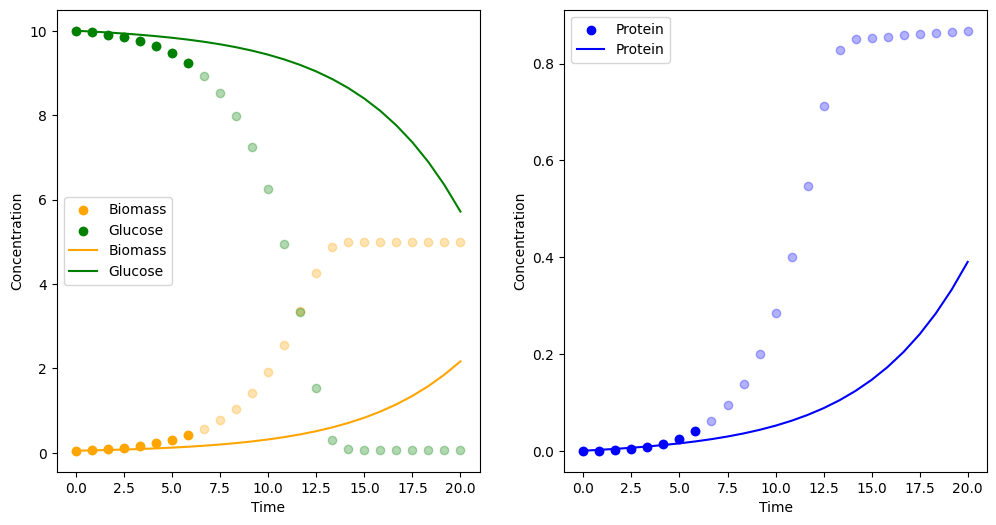

In [ ]:
X, P, S, V = simulate(mu_max_A, 'A').transpose()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(df['RTime'], df['Biomass'], color='orange', label="_Biomass", alpha=0.3)
ax[0].scatter(df['RTime'], df['Glucose'], color='green', label="_Glucose", alpha=0.3)
ax[0].scatter(train_df['RTime'], train_df['Biomass'], color='orange', label='Biomass', alpha=1.0)
ax[0].scatter(train_df['RTime'], train_df['Glucose'], color='green', label='Glucose', alpha=1.0)
ax[1].scatter(df['RTime'], df['Protein'], color='blue', label='_Protein', alpha=0.3)   
ax[1].scatter(train_df['RTime'], train_df['Protein'], color='blue', label='Protein', alpha=1.0)

ax[0].plot(t, X, color='orange', label='Biomass')
ax[0].plot(t, S, color='green', label='Glucose')
ax[1].plot(t, P, color='blue', label='Protein')

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Concentration')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Concentration')

plt.show()